# notebooks/4_privacy_attacks.ipynb

"""
Project 4: Privacy-Preserving Alignment
Notebook 4: Privacy Attacks & Verification

Purpose: Test privacy guarantees via membership inference attacks
Models: All DPO and RLHF variants (baseline + DP)
Time: ~45 minutes on T4
"""

In [1]:

# CELL 1: Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

if os.path.exists('/content/drive/MyDrive'):
    print("Google Drive mounted successfully")
else:
    print("Drive mount failed")

Mounted at /content/drive
Google Drive mounted successfully


In [2]:
# CELL 2: Setup
import sys
import torch
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import shutil

print("Imports complete")

Imports complete


In [3]:

# CELL 3: Configure Paths
DRIVE_BASE = Path("/content/drive/MyDrive/Project4_Privacy_Alignment")
DRIVE_DATA_DIR = DRIVE_BASE / "data"
DRIVE_MODELS_DIR = DRIVE_BASE / "models"
DRIVE_RESULTS_DIR = DRIVE_BASE / "results"

LOCAL_BASE = Path("/content")
LOCAL_DATA_DIR = LOCAL_BASE / "data"
LOCAL_RESULTS_DIR = LOCAL_BASE / "results"

for dir_path in [LOCAL_DATA_DIR, LOCAL_RESULTS_DIR, DRIVE_RESULTS_DIR]:
    dir_path.mkdir(exist_ok=True, parents=True)

print("Directories configured")
print(f"Models will load from: {DRIVE_MODELS_DIR}")
print(f"Results will save to: {DRIVE_RESULTS_DIR}")

Directories configured
Models will load from: /content/drive/MyDrive/Project4_Privacy_Alignment/models
Results will save to: /content/drive/MyDrive/Project4_Privacy_Alignment/results


In [4]:


# CELL 4: Load Data
print("\nLoading data from Drive...")

drive_dataset_path = DRIVE_DATA_DIR / "hh_rlhf_processed"
local_dataset_path = LOCAL_DATA_DIR / "hh_rlhf_processed"

if not drive_dataset_path.exists():
    raise FileNotFoundError(
        f"Data not found in Drive at {drive_dataset_path}\n"
        f"Please run Notebook 0 first to prepare data."
    )

if local_dataset_path.exists():
    shutil.rmtree(local_dataset_path)

print("   Copying from Drive to local...")
shutil.copytree(drive_dataset_path, local_dataset_path)

shutil.copy2(
    DRIVE_DATA_DIR / "config.json",
    LOCAL_DATA_DIR / "config.json"
)

dataset = load_from_disk(str(local_dataset_path))
train_dataset = dataset['train']
test_dataset = dataset['test']

with open(LOCAL_DATA_DIR / "config.json") as f:
    config = json.load(f)

print(f"Data loaded")
print(f"   Train: {len(train_dataset)} samples (members)")
print(f"   Test: {len(test_dataset)} samples (non-members)")
print(f"   Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")


Loading data from Drive...
   Copying from Drive to local...
Data loaded
   Train: 18000 samples (members)
   Test: 2000 samples (non-members)
   Device: Tesla T4


In [5]:
# CELL 5: Initialize Tokenizers
print("\nLoading tokenizers...")

tokenizer = AutoTokenizer.from_pretrained(config['policy_model'])
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

MAX_LENGTH = config.get('max_length', 224)

print(f"Tokenizer loaded: {config['policy_model']}")
print(f"MAX_LENGTH: {MAX_LENGTH}")


Loading tokenizers...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizer loaded: gpt2
MAX_LENGTH: 512


In [6]:


# CELL 6: Privacy Attack Functions
def compute_loss_on_sample(model, tokenizer, text, max_length=224):
    """Compute loss on a single sample"""
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=max_length,
        padding='max_length'
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs, labels=inputs['input_ids'])
        loss = outputs.loss.item()

    return loss

def membership_inference_attack(model, tokenizer, train_samples, test_samples,
                                max_samples=500):
    """
    Perform membership inference attack using loss threshold

    Intuition: Training samples should have lower loss than test samples
    """
    print(f"   Running membership inference attack...")
    print(f"   Using {max_samples} samples from each set")

    # Compute losses on training samples (members)
    train_losses = []
    for i, example in enumerate(tqdm(train_samples.select(range(min(max_samples, len(train_samples)))),
                                     desc="   Computing member losses")):
        text = f"Human: {example['prompt']}\n\nAssistant: {example['chosen']}"
        loss = compute_loss_on_sample(model, tokenizer, text, MAX_LENGTH)
        train_losses.append(loss)

    # Compute losses on test samples (non-members)
    test_losses = []
    for i, example in enumerate(tqdm(test_samples.select(range(min(max_samples, len(test_samples)))),
                                     desc="   Computing non-member losses")):
        text = f"Human: {example['prompt']}\n\nAssistant: {example['chosen']}"
        loss = compute_loss_on_sample(model, tokenizer, text, MAX_LENGTH)
        test_losses.append(loss)

    # Create labels (1 = member, 0 = non-member)
    losses = np.array(train_losses + test_losses)
    labels = np.array([1] * len(train_losses) + [0] * len(test_losses))

    # Simple threshold attack: lower loss = member
    # Invert losses so higher score = member
    scores = -losses

    # Compute metrics
    auc = roc_auc_score(labels, scores)

    # Find optimal threshold
    fpr, tpr, thresholds = roc_curve(labels, scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    predictions = (scores > optimal_threshold).astype(int)
    accuracy = (predictions == labels).mean()

    # True positive rate and false positive rate at optimal threshold
    tpr_opt = tpr[optimal_idx]
    fpr_opt = fpr[optimal_idx]

    results = {
        'auc': auc,
        'accuracy': accuracy,
        'tpr': tpr_opt,
        'fpr': fpr_opt,
        'train_loss_mean': np.mean(train_losses),
        'train_loss_std': np.std(train_losses),
        'test_loss_mean': np.mean(test_losses),
        'test_loss_std': np.std(test_losses),
        'loss_separation': np.mean(test_losses) - np.mean(train_losses),
        'train_losses': train_losses,
        'test_losses': test_losses,
        'labels': labels,
        'scores': scores,
        'fpr': fpr,
        'tpr': tpr,
    }

    print(f"   Attack AUC: {auc:.4f}")
    print(f"   Attack Accuracy: {accuracy:.4f}")
    print(f"   Member loss: {np.mean(train_losses):.4f} ± {np.std(train_losses):.4f}")
    print(f"   Non-member loss: {np.mean(test_losses):.4f} ± {np.std(test_losses):.4f}")

    return results

def advanced_membership_attack(model, tokenizer, train_samples, test_samples,
                              max_samples=500):
    """
    Advanced attack using multiple features + ML classifier
    """
    print(f"   Running advanced membership inference attack...")

    def extract_features(examples, is_member):
        features = []
        labels = []

        for example in tqdm(examples, desc=f"   Extracting {'member' if is_member else 'non-member'} features"):
            text = f"Human: {example['prompt']}\n\nAssistant: {example['chosen']}"

            # Feature 1: Loss
            loss = compute_loss_on_sample(model, tokenizer, text, MAX_LENGTH)

            # Feature 2: Perplexity
            perplexity = np.exp(loss)

            # Feature 3: Text length
            text_len = len(text.split())

            features.append([loss, perplexity, text_len])
            labels.append(1 if is_member else 0)

        return features, labels

    # Extract features
    train_features, train_labels = extract_features(
        train_samples.select(range(min(max_samples, len(train_samples)))),
        is_member=True
    )
    test_features, test_labels = extract_features(
        test_samples.select(range(min(max_samples, len(test_samples)))),
        is_member=False
    )

    # Combine
    X = np.array(train_features + test_features)
    y = np.array(train_labels + test_labels)

    # Train classifier (use first 70% for training classifier)
    split_idx = int(0.7 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_train, y_train)

    # Predict
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = clf.score(X_test, y_test)

    results = {
        'auc': auc,
        'accuracy': accuracy,
        'feature_importance': clf.coef_[0].tolist(),
    }

    print(f"   Advanced attack AUC: {auc:.4f}")
    print(f"   Advanced attack Accuracy: {accuracy:.4f}")

    return results

print("Privacy attack functions loaded")

Privacy attack functions loaded


In [7]:


# CELL 7: Load Model Function
def load_model(model_name):
    """Load a trained model from Drive"""
    model_path = DRIVE_MODELS_DIR / model_name

    if not model_path.exists():
        print(f"   WARNING: Model not found: {model_name}")
        return None

    try:
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            device_map='auto',
            torch_dtype=torch.float16
        )
        model.eval()
        return model
    except Exception as e:
        print(f"   ERROR loading {model_name}: {e}")
        return None

print("Model loader ready")

Model loader ready


In [8]:

# CELL 8: Run Attacks on All Models
print("\n" + "="*60)
print("RUNNING MEMBERSHIP INFERENCE ATTACKS")
print("="*60)

attack_results = {}

# Models to attack
models_to_attack = [
    'sft_baseline',
    'dpo_baseline',
    'dp_dpo_eps8.0',
    'dp_dpo_eps4.0',
    'dp_dpo_eps1.0',
    'rlhf_baseline',
    'dp_rlhf_eps8.0',
    'dp_rlhf_eps1.0',
]

for model_name in models_to_attack:
    print(f"\n{'='*60}")
    print(f"Attacking: {model_name}")
    print(f"{'='*60}")

    # Load model
    model = load_model(model_name)
    if model is None:
        continue

    # Basic attack
    print("\n1. Basic Loss-based Attack:")
    basic_results = membership_inference_attack(
        model, tokenizer, train_dataset, test_dataset, max_samples=500
    )

    # Advanced attack
    print("\n2. Advanced ML-based Attack:")
    advanced_results = advanced_membership_attack(
        model, tokenizer, train_dataset, test_dataset, max_samples=200
    )

    # Store results
    attack_results[model_name] = {
        'basic_attack': {k: v for k, v in basic_results.items()
                        if k not in ['train_losses', 'test_losses', 'labels', 'scores', 'fpr', 'tpr']},
        'advanced_attack': advanced_results,
        'basic_attack_curves': {
            'fpr': basic_results['fpr'].tolist(),
            'tpr': basic_results['tpr'].tolist(),
        }
    }

    # Cleanup
    del model
    torch.cuda.empty_cache()

print("\n" + "="*60)
print("ATTACKS COMPLETE")
print("="*60)


RUNNING MEMBERSHIP INFERENCE ATTACKS

Attacking: sft_baseline


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


1. Basic Loss-based Attack:
   Running membership inference attack...
   Using 500 samples from each set


   Computing member losses:   0%|          | 0/500 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


   Computing non-member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Attack AUC: 0.4866
   Attack Accuracy: 0.5090
   Member loss: 0.6517 ± 0.4664
   Non-member loss: 0.6178 ± 0.4175

2. Advanced ML-based Attack:
   Running advanced membership inference attack...


   Extracting member features:   0%|          | 0/200 [00:00<?, ?it/s]

   Extracting non-member features:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


   Advanced attack AUC: nan
   Advanced attack Accuracy: 0.0000

Attacking: dpo_baseline

1. Basic Loss-based Attack:
   Running membership inference attack...
   Using 500 samples from each set


   Computing member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Computing non-member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Attack AUC: 0.5123
   Attack Accuracy: 0.5210
   Member loss: 9.1442 ± 0.7182
   Non-member loss: 9.2202 ± 0.4326

2. Advanced ML-based Attack:
   Running advanced membership inference attack...


   Extracting member features:   0%|          | 0/200 [00:00<?, ?it/s]

   Extracting non-member features:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


   Advanced attack AUC: nan
   Advanced attack Accuracy: 0.0000

Attacking: dp_dpo_eps8.0

1. Basic Loss-based Attack:
   Running membership inference attack...
   Using 500 samples from each set


   Computing member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Computing non-member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Attack AUC: 0.5119
   Attack Accuracy: 0.5220
   Member loss: 9.1604 ± 0.7233
   Non-member loss: 9.2363 ± 0.4381

2. Advanced ML-based Attack:
   Running advanced membership inference attack...


   Extracting member features:   0%|          | 0/200 [00:00<?, ?it/s]

   Extracting non-member features:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


   Advanced attack AUC: nan
   Advanced attack Accuracy: 0.0000

Attacking: dp_dpo_eps4.0

1. Basic Loss-based Attack:
   Running membership inference attack...
   Using 500 samples from each set


   Computing member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Computing non-member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Attack AUC: 0.5108
   Attack Accuracy: 0.5200
   Member loss: 9.1408 ± 0.7258
   Non-member loss: 9.2166 ± 0.4420

2. Advanced ML-based Attack:
   Running advanced membership inference attack...


   Extracting member features:   0%|          | 0/200 [00:00<?, ?it/s]

   Extracting non-member features:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


   Advanced attack AUC: nan
   Advanced attack Accuracy: 0.0000

Attacking: dp_dpo_eps1.0

1. Basic Loss-based Attack:
   Running membership inference attack...
   Using 500 samples from each set


   Computing member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Computing non-member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Attack AUC: 0.5114
   Attack Accuracy: 0.5220
   Member loss: 9.1512 ± 0.7208
   Non-member loss: 9.2267 ± 0.4360

2. Advanced ML-based Attack:
   Running advanced membership inference attack...


   Extracting member features:   0%|          | 0/200 [00:00<?, ?it/s]

   Extracting non-member features:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


   Advanced attack AUC: nan
   Advanced attack Accuracy: 0.0000

Attacking: rlhf_baseline

1. Basic Loss-based Attack:
   Running membership inference attack...
   Using 500 samples from each set


   Computing member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Computing non-member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Attack AUC: 0.5054
   Attack Accuracy: 0.5220
   Member loss: 8.5214 ± 0.7170
   Non-member loss: 8.6004 ± 0.4538

2. Advanced ML-based Attack:
   Running advanced membership inference attack...


   Extracting member features:   0%|          | 0/200 [00:00<?, ?it/s]

   Extracting non-member features:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


   Advanced attack AUC: nan
   Advanced attack Accuracy: 0.0000

Attacking: dp_rlhf_eps8.0

1. Basic Loss-based Attack:
   Running membership inference attack...
   Using 500 samples from each set


   Computing member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Computing non-member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Attack AUC: 0.5118
   Attack Accuracy: 0.5220
   Member loss: 9.0107 ± 0.7137
   Non-member loss: 9.0879 ± 0.4302

2. Advanced ML-based Attack:
   Running advanced membership inference attack...


   Extracting member features:   0%|          | 0/200 [00:00<?, ?it/s]

   Extracting non-member features:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


   Advanced attack AUC: nan
   Advanced attack Accuracy: 0.0000

Attacking: dp_rlhf_eps1.0

1. Basic Loss-based Attack:
   Running membership inference attack...
   Using 500 samples from each set


   Computing member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Computing non-member losses:   0%|          | 0/500 [00:00<?, ?it/s]

   Attack AUC: 0.5118
   Attack Accuracy: 0.5220
   Member loss: 9.0107 ± 0.7137
   Non-member loss: 9.0879 ± 0.4302

2. Advanced ML-based Attack:
   Running advanced membership inference attack...


   Extracting member features:   0%|          | 0/200 [00:00<?, ?it/s]

   Extracting non-member features:   0%|          | 0/200 [00:00<?, ?it/s]

   Advanced attack AUC: nan
   Advanced attack Accuracy: 0.0000

ATTACKS COMPLETE


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [9]:



# CELL 9: Create Results Summary
print("\n" + "="*60)
print("ATTACK RESULTS SUMMARY")
print("="*60)

# Create DataFrame for basic attacks
basic_df = pd.DataFrame({
    model: results['basic_attack']
    for model, results in attack_results.items()
}).T

print("\nBasic Loss-based Attack Results:")
print(basic_df[['auc', 'accuracy', 'loss_separation']].to_string())

# Create DataFrame for advanced attacks
advanced_df = pd.DataFrame({
    model: results['advanced_attack']
    for model, results in attack_results.items()
}).T

print("\n\nAdvanced ML-based Attack Results:")
print(advanced_df[['auc', 'accuracy']].to_string())

# Save results
results_path = DRIVE_RESULTS_DIR / "privacy_attack_results.csv"
basic_df.to_csv(results_path)
print(f"\nResults saved to: {results_path}")


ATTACK RESULTS SUMMARY

Basic Loss-based Attack Results:
                     auc  accuracy  loss_separation
sft_baseline    0.486626     0.509        -0.033937
dpo_baseline    0.512286     0.521         0.076028
dp_dpo_eps8.0   0.511886     0.522         0.075825
dp_dpo_eps4.0   0.510782     0.520         0.075809
dp_dpo_eps1.0   0.511430     0.522         0.075525
rlhf_baseline   0.505366     0.522         0.079092
dp_rlhf_eps8.0  0.511802     0.522         0.077240
dp_rlhf_eps1.0  0.511802     0.522         0.077240


Advanced ML-based Attack Results:
                auc accuracy
sft_baseline    NaN      0.0
dpo_baseline    NaN      0.0
dp_dpo_eps8.0   NaN      0.0
dp_dpo_eps4.0   NaN      0.0
dp_dpo_eps1.0   NaN      0.0
rlhf_baseline   NaN      0.0
dp_rlhf_eps8.0  NaN      0.0
dp_rlhf_eps1.0  NaN      0.0

Results saved to: /content/drive/MyDrive/Project4_Privacy_Alignment/results/privacy_attack_results.csv



CREATING VISUALIZATIONS


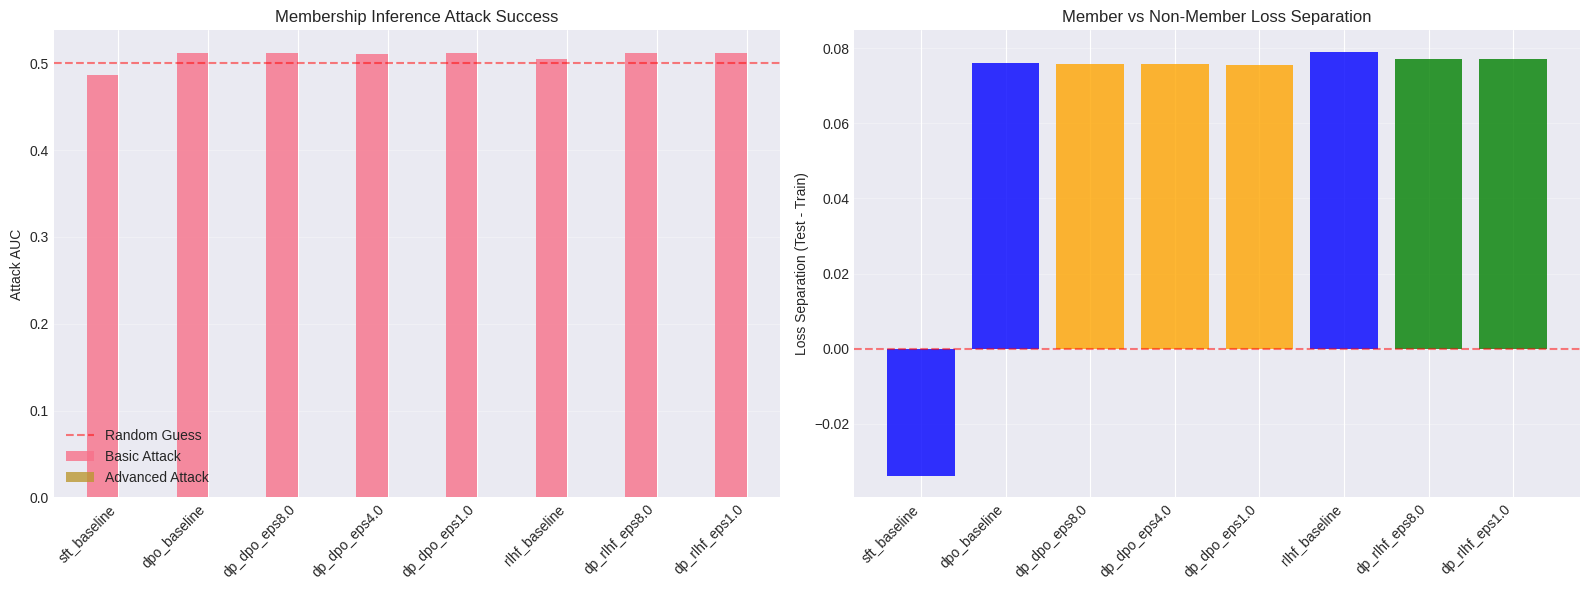

Attack comparison plot saved


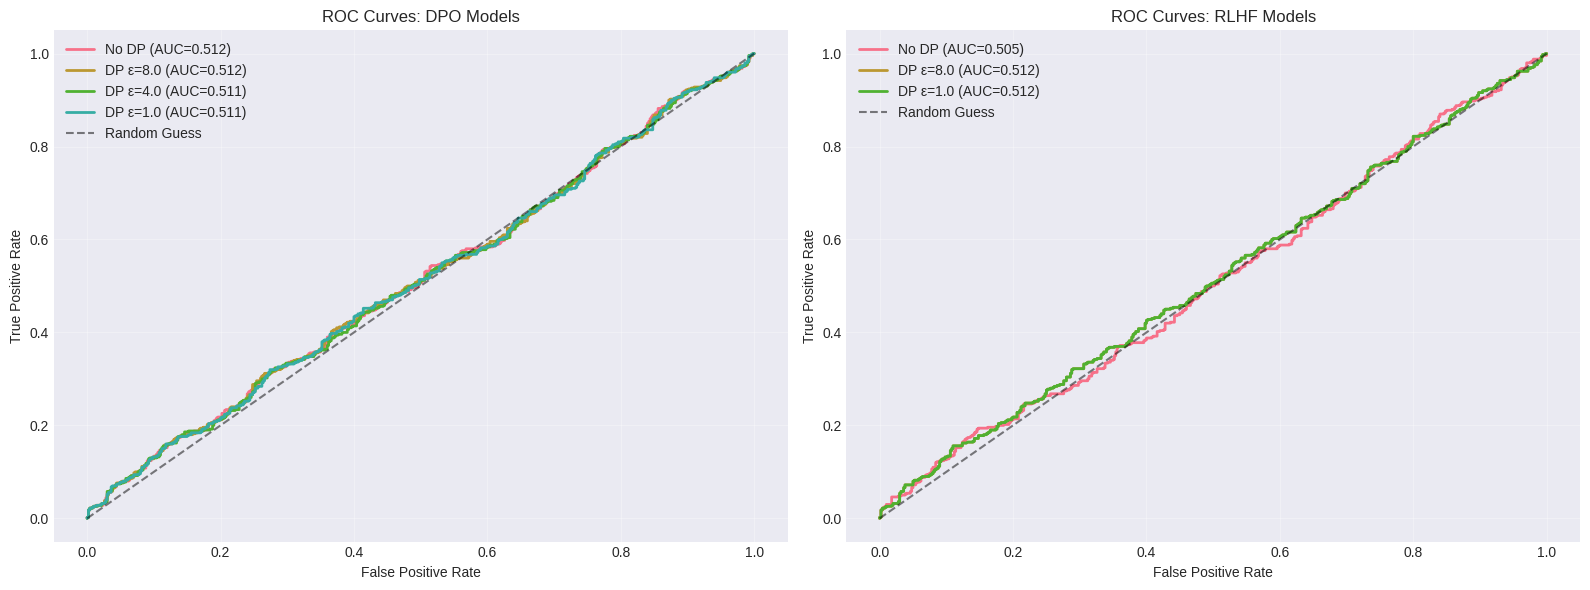

ROC curves saved


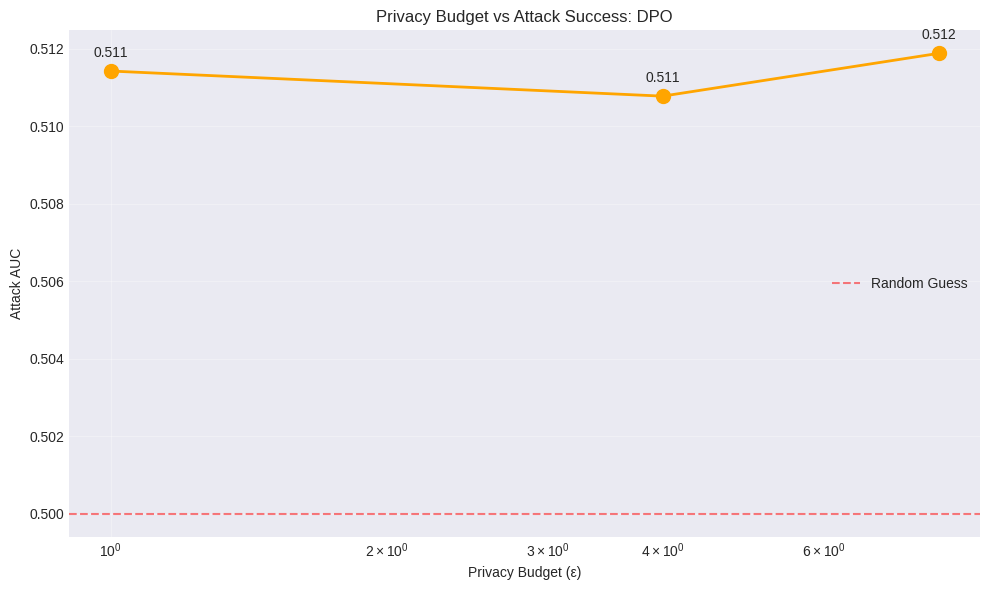

DPO privacy-attack plot saved


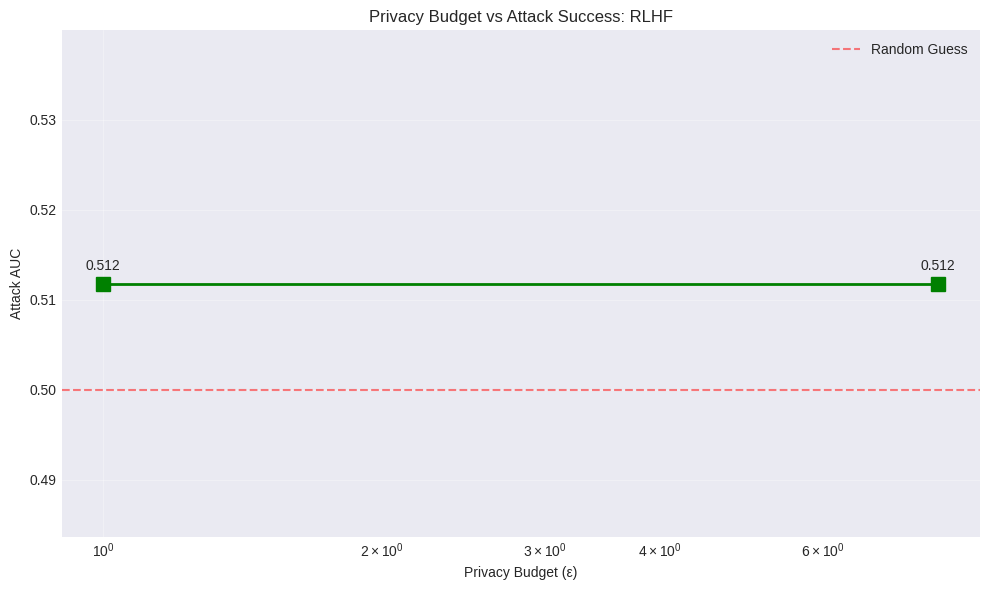

RLHF privacy-attack plot saved

All visualizations saved to: /content/drive/MyDrive/Project4_Privacy_Alignment/results


In [10]:




# CELL 10: Visualizations
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Figure 1: Attack AUC Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

models = list(attack_results.keys())
basic_aucs = [attack_results[m]['basic_attack']['auc'] for m in models]
advanced_aucs = [attack_results[m]['advanced_attack']['auc'] for m in models]

x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, basic_aucs, width, label='Basic Attack', alpha=0.8)
ax1.bar(x + width/2, advanced_aucs, width, label='Advanced Attack', alpha=0.8)
ax1.axhline(y=0.5, color='red', linestyle='--', label='Random Guess', alpha=0.5)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.set_ylabel('Attack AUC')
ax1.set_title('Membership Inference Attack Success')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Figure 1b: Loss Separation
loss_seps = [attack_results[m]['basic_attack']['loss_separation'] for m in models]
colors = ['blue' if 'baseline' in m else 'orange' if 'dpo' in m else 'green'
          for m in models]

ax2.bar(range(len(models)), loss_seps, color=colors, alpha=0.8)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.set_ylabel('Loss Separation (Test - Train)')
ax2.set_title('Member vs Non-Member Loss Separation')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(DRIVE_RESULTS_DIR / 'attack_success_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Attack comparison plot saved")

# Figure 2: ROC Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# DPO models
dpo_models = [m for m in models if 'dpo' in m]
for model in dpo_models:
    fpr = attack_results[model]['basic_attack_curves']['fpr']
    tpr = attack_results[model]['basic_attack_curves']['tpr']
    auc = attack_results[model]['basic_attack']['auc']
    label = model.replace('dp_dpo_eps', 'DP ε=').replace('dpo_baseline', 'No DP')
    ax1.plot(fpr, tpr, label=f'{label} (AUC={auc:.3f})', linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Random Guess', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves: DPO Models')
ax1.legend()
ax1.grid(True, alpha=0.3)

# RLHF models
rlhf_models = [m for m in models if 'rlhf' in m]
for model in rlhf_models:
    fpr = attack_results[model]['basic_attack_curves']['fpr']
    tpr = attack_results[model]['basic_attack_curves']['tpr']
    auc = attack_results[model]['basic_attack']['auc']
    label = model.replace('dp_rlhf_eps', 'DP ε=').replace('rlhf_baseline', 'No DP')
    ax2.plot(fpr, tpr, label=f'{label} (AUC={auc:.3f})', linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', label='Random Guess', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves: RLHF Models')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DRIVE_RESULTS_DIR / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curves saved")

# Figure 3: Privacy Budget vs Attack Success (DPO)
if len(dpo_models) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))

    epsilon_map = {
        'dpo_baseline': float('inf'),
        'dp_dpo_eps1.0': 1.0,
        'dp_dpo_eps4.0': 4.0,
        'dp_dpo_eps8.0': 8.0,
    }

    epsilons = [epsilon_map.get(m, 0) for m in dpo_models]
    aucs = [attack_results[m]['basic_attack']['auc'] for m in dpo_models]

    # Sort by epsilon
    sorted_data = sorted(zip(epsilons, aucs, dpo_models))
    epsilons, aucs, labels = zip(*sorted_data)

    ax.plot(epsilons, aucs, marker='o', linewidth=2, markersize=10, color='orange')
    ax.axhline(y=0.5, color='red', linestyle='--', label='Random Guess', alpha=0.5)

    for i, (eps, auc, label) in enumerate(zip(epsilons, aucs, labels)):
        ax.annotate(f'{auc:.3f}', (eps, auc), textcoords="offset points",
                   xytext=(0,10), ha='center')

    ax.set_xlabel('Privacy Budget (ε)')
    ax.set_ylabel('Attack AUC')
    ax.set_title('Privacy Budget vs Attack Success: DPO')
    ax.set_xscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(DRIVE_RESULTS_DIR / 'privacy_vs_attack_dpo.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("DPO privacy-attack plot saved")

# Figure 4: Privacy Budget vs Attack Success (RLHF)
if len(rlhf_models) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))

    epsilon_map = {
        'rlhf_baseline': float('inf'),
        'dp_rlhf_eps1.0': 1.0,
        'dp_rlhf_eps8.0': 8.0,
    }

    epsilons = [epsilon_map.get(m, 0) for m in rlhf_models]
    aucs = [attack_results[m]['basic_attack']['auc'] for m in rlhf_models]

    # Sort by epsilon
    sorted_data = sorted(zip(epsilons, aucs, rlhf_models))
    epsilons, aucs, labels = zip(*sorted_data)

    ax.plot(epsilons, aucs, marker='s', linewidth=2, markersize=10, color='green')
    ax.axhline(y=0.5, color='red', linestyle='--', label='Random Guess', alpha=0.5)

    for i, (eps, auc, label) in enumerate(zip(epsilons, aucs, labels)):
        ax.annotate(f'{auc:.3f}', (eps, auc), textcoords="offset points",
                   xytext=(0,10), ha='center')

    ax.set_xlabel('Privacy Budget (ε)')
    ax.set_ylabel('Attack AUC')
    ax.set_title('Privacy Budget vs Attack Success: RLHF')
    ax.set_xscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(DRIVE_RESULTS_DIR / 'privacy_vs_attack_rlhf.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("RLHF privacy-attack plot saved")

print("\nAll visualizations saved to:", DRIVE_RESULTS_DIR)

In [11]:






# CELL 11: Privacy Analysis
print("\n" + "="*60)
print("PRIVACY ANALYSIS")
print("="*60)

print("\n1. Privacy Protection Effectiveness:")
print("\nDPO Track:")
if 'dpo_baseline' in attack_results and 'dp_dpo_eps8.0' in attack_results:
    baseline_auc = attack_results['dpo_baseline']['basic_attack']['auc']
    dp8_auc = attack_results['dp_dpo_eps8.0']['basic_attack']['auc']
    reduction = ((baseline_auc - dp8_auc) / (baseline_auc - 0.5)) * 100
    print(f"   Baseline attack AUC: {baseline_auc:.4f}")
    print(f"   DP (ε=8) attack AUC: {dp8_auc:.4f}")
    print(f"   Privacy improvement: {reduction:.1f}%")

print("\nRLHF Track:")
if 'rlhf_baseline' in attack_results and 'dp_rlhf_eps8.0' in attack_results:
    baseline_auc = attack_results['rlhf_baseline']['basic_attack']['auc']
    dp8_auc = attack_results['dp_rlhf_eps8.0']['basic_attack']['auc']
    reduction = ((baseline_auc - dp8_auc) / (baseline_auc - 0.5)) * 100
    print(f"   Baseline attack AUC: {baseline_auc:.4f}")
    print(f"   DP (ε=8) attack AUC: {dp8_auc:.4f}")
    print(f"   Privacy improvement: {reduction:.1f}%")

print("\n2. Epsilon Sensitivity:")
print("\nDPO - Attack AUC by epsilon:")
for model in ['dpo_baseline', 'dp_dpo_eps8.0', 'dp_dpo_eps4.0', 'dp_dpo_eps1.0']:
    if model in attack_results:
        auc = attack_results[model]['basic_attack']['auc']
        eps = 'inf' if 'baseline' in model else model.split('eps')[1]
        print(f"   ε={eps}: {auc:.4f}")

print("\nRLHF - Attack AUC by epsilon:")
for model in ['rlhf_baseline', 'dp_rlhf_eps8.0', 'dp_rlhf_eps1.0']:
    if model in attack_results:
        auc = attack_results[model]['basic_attack']['auc']
        eps = 'inf' if 'baseline' in model else model.split('eps')[1]
        print(f"   ε={eps}: {auc:.4f}")



PRIVACY ANALYSIS

1. Privacy Protection Effectiveness:

DPO Track:
   Baseline attack AUC: 0.5123
   DP (ε=8) attack AUC: 0.5119
   Privacy improvement: 3.3%

RLHF Track:
   Baseline attack AUC: 0.5054
   DP (ε=8) attack AUC: 0.5118
   Privacy improvement: -119.9%

2. Epsilon Sensitivity:

DPO - Attack AUC by epsilon:
   ε=inf: 0.5123
   ε=8.0: 0.5119
   ε=4.0: 0.5108
   ε=1.0: 0.5114

RLHF - Attack AUC by epsilon:
   ε=inf: 0.5054
   ε=8.0: 0.5118
   ε=1.0: 0.5118


In [12]:

# CELL 12: Export Final Report
print("\n" + "="*60)
print("EXPORTING PRIVACY ATTACK REPORT")
print("="*60)

report = {
    'attack_date': str(pd.Timestamp.now()),
    'config': config,
    'num_train_samples': len(train_dataset),
    'num_test_samples': len(test_dataset),
    'models_attacked': list(attack_results.keys()),
    'attack_results': attack_results,
}

report_path = DRIVE_RESULTS_DIR / "privacy_attack_report.json"
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2, default=str)

print(f"Report saved to: {report_path}")

print("\n" + "="*60)
print("PRIVACY ATTACKS COMPLETE")
print("="*60)
print(f"\nAll results saved to: {DRIVE_RESULTS_DIR}")
print("\nFiles created:")
print("  - privacy_attack_results.csv")
print("  - privacy_attack_report.json")
print("  - attack_success_comparison.png")
print("  - roc_curves.png")
print("  - privacy_vs_attack_dpo.png")
print("  - privacy_vs_attack_rlhf.png")





EXPORTING PRIVACY ATTACK REPORT
Report saved to: /content/drive/MyDrive/Project4_Privacy_Alignment/results/privacy_attack_report.json

PRIVACY ATTACKS COMPLETE

All results saved to: /content/drive/MyDrive/Project4_Privacy_Alignment/results

Files created:
  - privacy_attack_results.csv
  - privacy_attack_report.json
  - attack_success_comparison.png
  - roc_curves.png
  - privacy_vs_attack_dpo.png
  - privacy_vs_attack_rlhf.png
